# Cat Breed Project - Transfer Learning

The Maine Coon cats and Norwegian Forest cats look very similar, and some experts believe that the Maine Coon is a descendant of Norwegian Forest cats as they shared very similar traits such as big ears, long silky fur etc.

One significant difference between the two big cats is their head shape. The Maine Coon has a square head being slightly elongated and a square muzzle. While the Norwegian Forest cat has an almost equilateral triangular head.

This project aims to use transfer learning to differentiate two different cat breed: Maine Coon cat and Norwegian Forest Cat. 

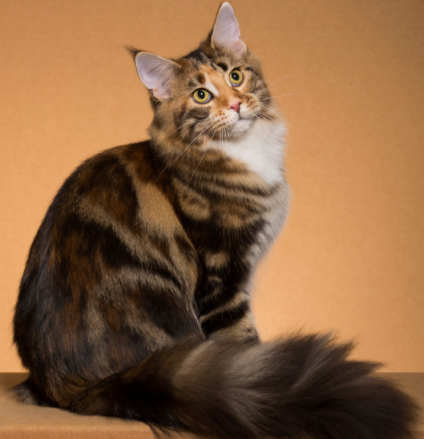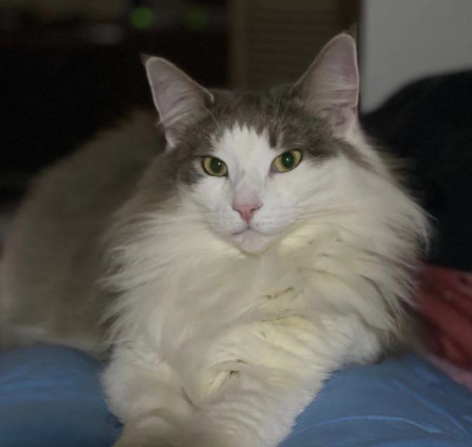

P.S Picture on the left is a Maine Coon cat while picture on the right is a Norwegian Forest cat.


## Download the Dataset

In [ ]:
!ls

sample_data


In [ ]:
!wget -qq https://www.dropbox.com/s/c7vi01etjg0iu01/catbreed.zip
!unzip -qq catbreed.zip
!rm catbreed.zip

!ls

catbreed  sample_data


In [ ]:
#a total of 100 pictures of Maine Coon(same for Norwegian Forest dataset)
!ls catbreed/MaineCoon 

100.PNG  19.PNG  28.PNG  37.PNG  46.PNG  55.PNG  64.PNG  73.PNG  82.PNG  91.PNG
10.PNG	 1.PNG	 29.PNG  38.PNG  47.PNG  56.PNG  65.PNG  74.PNG  83.PNG  92.PNG
11.PNG	 20.PNG  2.PNG	 39.PNG  48.PNG  57.PNG  66.PNG  75.PNG  84.PNG  93.PNG
12.PNG	 21.PNG  30.PNG  3.PNG	 49.PNG  58.PNG  67.PNG  76.PNG  85.PNG  94.PNG
13.PNG	 22.PNG  31.PNG  40.PNG  4.PNG	 59.PNG  68.PNG  77.PNG  86.PNG  95.PNG
14.PNG	 23.PNG  32.PNG  41.PNG  50.PNG  5.PNG	 69.PNG  78.PNG  87.PNG  96.PNG
15.PNG	 24.PNG  33.PNG  42.PNG  51.PNG  60.PNG  6.PNG	 79.PNG  88.PNG  97.PNG
16.PNG	 25.PNG  34.PNG  43.PNG  52.PNG  61.PNG  70.PNG  7.PNG	 89.PNG  98.PNG
17.PNG	 26.PNG  35.PNG  44.PNG  53.PNG  62.PNG  71.PNG  80.PNG  8.PNG	 99.PNG
18.PNG	 27.PNG  36.PNG  45.PNG  54.PNG  63.PNG  72.PNG  81.PNG  90.PNG  9.PNG


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, json
from glob import glob
import numpy as np

import tensorflow as tf

from tensorflow.keras import optimizers

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback

In [ ]:
print(tf.__version__)
print(tf.keras.__version__)

2.4.0
2.4.0


In [ ]:
!ls catbreed

MaineCoon  NorwegianForest


## Converting raw files in folders into something we can feed into tf.data
- use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.

- split them up so we have 10% for a testing set and the rest for training and shuffle them up.


In [ ]:
import glob
import pandas as pd

path = "catbreed"

data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.PNG' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))

df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
df.dtypes

                                   filename       class_name  class
0        /content/catbreed/MaineCoon/33.PNG        MaineCoon      0
1  /content/catbreed/NorwegianForest/61.PNG  NorwegianForest      1
2  /content/catbreed/NorwegianForest/77.PNG  NorwegianForest      1
3        /content/catbreed/MaineCoon/69.PNG        MaineCoon      0
4  /content/catbreed/NorwegianForest/95.PNG  NorwegianForest      1


filename        object
class_name    category
class             int8
dtype: object

In [ ]:
print("There are a total of", len(df),"data.")
print(df.shape)

# Split into train and validation sets
train_set_percentage = .9

df = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

#shuffle
df = df.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

df.head(5)

There are a total of 200 data.
(200, 3)


,filename,class_name,class
0,/content/catbreed/NorwegianForest/18.PNG,NorwegianForest,1
1,/content/catbreed/MaineCoon/4.PNG,MaineCoon,0
2,/content/catbreed/MaineCoon/66.PNG,MaineCoon,0
3,/content/catbreed/NorwegianForest/29.PNG,NorwegianForest,1
4,/content/catbreed/NorwegianForest/83.PNG,NorwegianForest,1


In [ ]:
print(df.shape)
print(df_val.shape)

df['class'].unique()

(180, 3)
(18, 3)


array([1, 0], dtype=int8)

MaineCoon          92
NorwegianForest    88
Name: class_name, dtype: int64


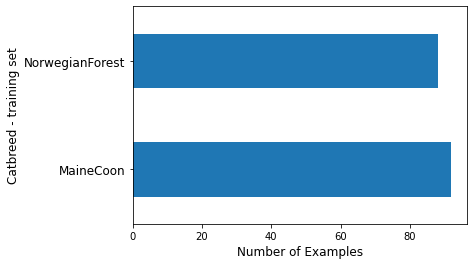

In [ ]:
print(df['class_name'].value_counts())

ax = df['class_name'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Catbreed - training set", fontsize=12)
ax.set_yticklabels(['MaineCoon','NorwegianForest'], rotation=0, fontsize=12)
plt.show()

## Make the pipeline for loading and resizing the images

In [ ]:
#number of classes
num_classes = 2

df.shape

(180, 3)

In [ ]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 224,224
batch_size = 16

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_png(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df['filename'].values, tf.string),
                                                    tf.cast(df['class'].values, tf.int32) ))
train_dataset= train_dataset.map(_parse_function)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.shuffle(100)
train_dataset = train_dataset.repeat(10)
train_dataset = train_dataset.batch(16, drop_remainder = True)

train_dataset

<BatchDataset shapes: ((16, 224, 224, 3), (16, 2)), types: (tf.float32, tf.float32)>

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.apply(tf.data.experimental.ignore_errors())
valid_dataset = valid_dataset.batch(16)

In [ ]:
train_dataset

<BatchDataset shapes: ((16, 224, 224, 3), (16, 2)), types: (tf.float32, tf.float32)>

- Download VGG network weights 


In [ ]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3),pooling=None)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# add a global spatial average pooling layer
x = base_model.output

#takes a average pooling in a way that flattenning an amount
x = GlobalAveragePooling2D()(x) 

# add a fully-connected layer
x = Dense(512, activation='relu')(x) #512 neurons

# and a logits layer - 2 classes
predictions = Dense(2, activation='softmax')(x)

#model to be trained
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary() #the 2 dense layers at the end are not trained

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable) #passing images only training the dense and globel average pooling

input_1  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_pool  Trainable = False
global_average_pooling2d_1  Trainable = True
dense_2  Trainable = True
dense_3  Trainable = True


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Select an optimizer and compile the model


In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.001)

model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
train_steps = int(180/16) #total trains set / batch_size
val_steps = int(20/16)
epochs = 1

print('train steps:',train_steps)
print('val steps:',val_steps)

## Fit the model

In [ ]:
# Train the model with validation 
history = model.fit( train_dataset, 
                    steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

11/11 [==============================] - 95s 9s/step - loss: 6.8707 - accuracy: 0.4119 - val_loss: 1.4659 - val_accuracy: 0.8125


In [ ]:
epochs = 4

# Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/4
11/11 [==============================] - 94s 9s/step - loss: 1.9151 - accuracy: 0.7330 - val_loss: 2.4849 - val_accuracy: 0.6875
Epoch 2/4
11/11 [==============================] - 93s 9s/step - loss: 0.8330 - accuracy: 0.8239 - val_loss: 0.5100 - val_accuracy: 0.8750
Epoch 3/4
11/11 [==============================] - 93s 9s/step - loss: 0.2267 - accuracy: 0.9091 - val_loss: 0.0910 - val_accuracy: 0.9375
Epoch 4/4
11/11 [==============================] - 93s 9s/step - loss: 0.1424 - accuracy: 0.9375 - val_loss: 0.2871 - val_accuracy: 0.8750


In [ ]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

1/1 [==============================] - 8s 8s/step - loss: 0.2871 - accuracy: 0.8750
model accuracy: 0.875


##Making Predictions

In [ ]:
!wget -qq https://www.dropbox.com/s/7yy2z83l04wobep/testing_catbreed.zip
!unzip -qq testing_catbreed.zip
!rm testing_catbreed.zip

!ls

catbreed  sample_data  testing_catbreed


In [ ]:
!ls testing_catbreed

MaineCoon1.PNG	MaineCoon3.PNG	      NorwegianForest2.PNG
MaineCoon2.PNG	NorwegianForest1.PNG  NorwegianForest3.PNG


In [ ]:
image_path = './testing_catbreed/'

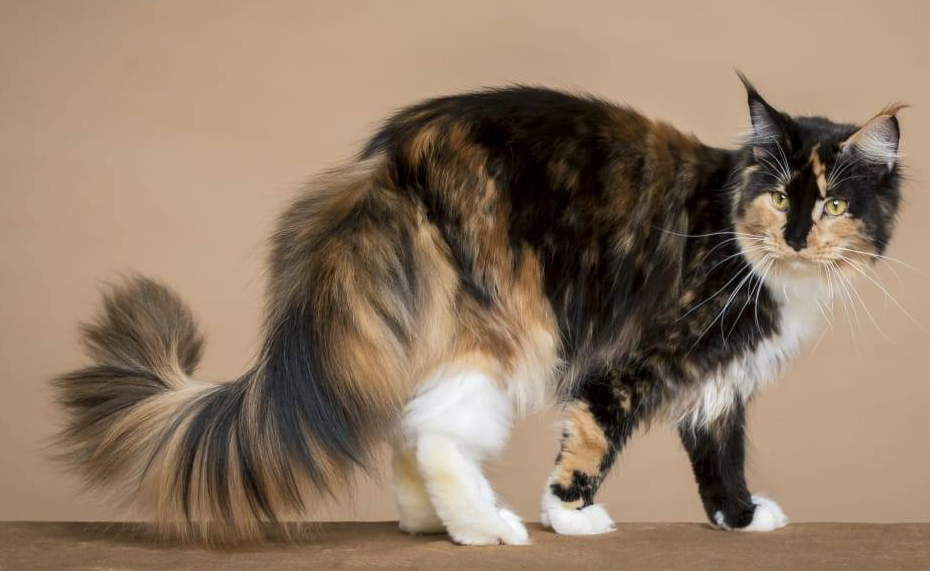

In [ ]:
from IPython.display import Image

image_name = 'MaineCoon3.PNG'
Image(image_path+image_name)

In [ ]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_name)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [ ]:
pred = model.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

Predicted: [[0.9500475  0.04995248]]
0


In [ ]:
result= pred[0][0]
if result< pred[0][1]:
    print("It is a Norwegian Forest Cat.")
else:
    print("It is a Maine Coon cat.")

It is a Maine Coon cat.


## Fine-tuning


In [ ]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True
global_average_pooling2d_1 True
dense_2 True
dense_3 True


In [ ]:
# Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = 2,
                   validation_data = valid_dataset,
                   validation_steps = val_steps)

Epoch 1/2
11/11 [==============================] - 94s 9s/step - loss: 0.0453 - accuracy: 0.9773 - val_loss: 0.0376 - val_accuracy: 1.0000
Epoch 2/2
11/11 [==============================] - 93s 9s/step - loss: 0.0137 - accuracy: 0.9943 - val_loss: 0.0147 - val_accuracy: 1.0000


In [ ]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

1/1 [==============================] - 8s 8s/step - loss: 0.0147 - accuracy: 1.0000
model accuracy: 1.0


##Credits
- Flowers Example with No Model - Preprocessing example [link text](https://colab.research.google.com/drive/1SEWTSdMAaPytRWfvZoOZdc2k3o-PVV26)
- JS04-06 Transfer Learning - cats and dogs [link text](https://colab.research.google.com/drive/1Hzwq-jgRHC2yMbq6tGnJooCbkTZaIBZr)